## Consistency

When it comes to choosing the number of clusters and the clustering algorithm, you need to measure *consistency* across subsamples or folds. Clusters are useful when similar data points get grouped together each time that the algorithm is run on different subsets of the same data. However, unlike the cross-validation and test-retest methods that you are familiar with from supervised learning, there's no formal metric for assessing how "similar" clusters are between different data subsets.  

To explore this consistency issue, you'll compare two-, three-, and four-cluster solutions for the *Iris* dataset. You'll be using the k-means algorithm and dividing the data into two samples of equal size. The goal will be to determine which $k$ value optimizes consistency across the two samples.

To compare the solutions, you'll plot the cluster assignments against two features created by PCA. This is just for visualization purposes—the solution is based on all the features in the data.

First, import the libraries that you'll use:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics

Next, load the *Iris* dataset from `sklearn.datasets` and standardize the features using `StandardScaler`. In order to observe consistency across subsamples, divide the *Iris* dataset into two random parts using `train_test_split` from `sklearn.model_selection`. Note that before doing this, you need to apply PCA to the scaled data, because you're using only the first two principal components for visualization purposes. When you divide the data in two, you also divide the principal components accordingly.

In [2]:
# Loading the data from scikit-learn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standardizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Splitting the data into four equally sized samples. First, break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=13579)

Next, apply k-means for the subsamples and get the predictions. To compare the results of different k-values, apply k-means by setting $k$ equal to `2`, `3`, and `4`.

In [17]:
# DataFrame to store features and predicted cluster memberships
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time that you go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. You use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the DataFrame.
for counter, data in enumerate([(X_half1, X_pcahalf1),(X_half2, X_pcahalf2)]):

    # Put the features into `ypred`
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]

    # Generate cluster predictions and store them for clusters 2-4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, n_init=10, random_state=455).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

Now, you can visualize the results. Below, graph the clustering results for each of the subsamples, first for the two-cluster solution and then for three- and four-cluster ones.

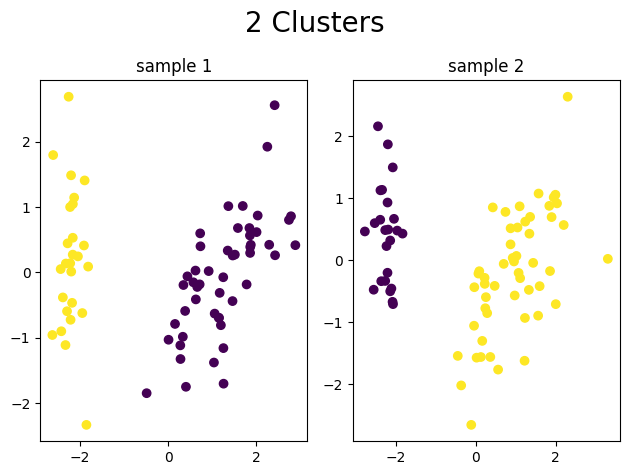

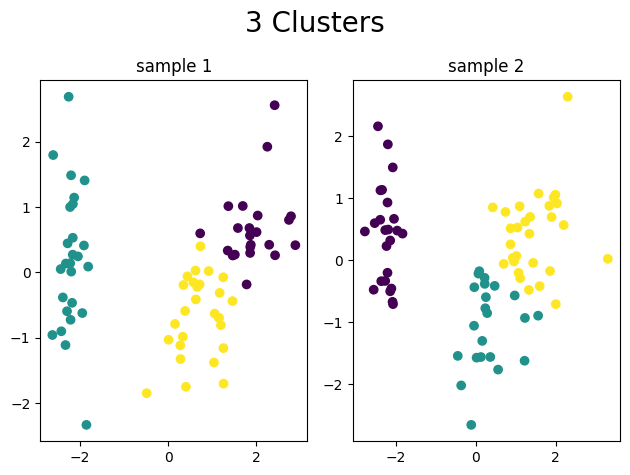

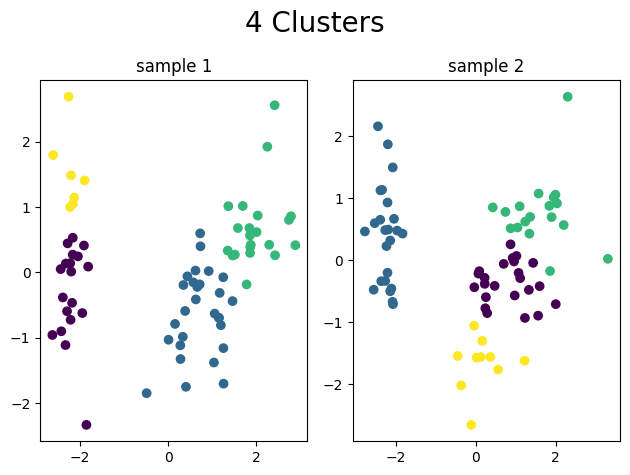

In [9]:
# For each  number of clusters, plot the clusters using the
# PCA features for each sample
for cluster in range(2, 5):

    # Make a grid of subplots
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample
    for i in range(2):

        # PCA-created features
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]

        # Cluster assignments
        c = ypred['clust{}_sample{}'.format(cluster, i)]

        # Assign the subplot to its place on the grid
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i+1))

    # Space out the plots so that the headings don't overlap axis values
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Ignoring the specific colors assigned to each cluster, it appears that the four-cluster solution isn't consistent across the subsamples. For example, in the first subsample, k-means assigns two clusters for the observations at the left side of the chart. However, in the second subsample, it assigns only a single cluster for the observations that reside on the left side of the chart.

On the other hand, the two- and three-cluster solutions yield consistent results in terms of cluster center and cluster shape. However, don't forget that you are evaluating this based on the first two principal components from PCA rather than the four-dimensional data actually used by k-means. So the information value of these plots depends on how much information is retained by the PCA. Although you know that the correct solution should give you three clusters, the two-cluster solution also does well in this example. In cases like this, you should always look for other measures to determine the consistency of the clustering algorithms.

One possible alternative might be to compute the descriptive statistics of the features for each solution. In a consistent solution, the descriptive statistics for each subsample should have similar scores for each feature.

**Note:** Notice that you ran the experiment above by randomly splitting the original sample into two. However, the randomness in selecting these subsamples may lead you to faulty conclusions. To see this, play with the `random_state` parameter of the `train_test_split` function, and check whether the interpretation remains valid for all the values of the `random_state` parameter. In these kinds of experiments, it's safer to check your results with different parameter values that may affect your samples.

Instead of relying on visualizations, which is somewhat subjective, you should find quantitative ways of evaluating the clustering algorithms. Next, you'll see some common methods of evaluating clustering solutions, first using the ground truths in the data and then without using the ground truths.

## When you have existing labels: Contingency tables, RI, and ARI

If you have a ground truth—some existing data-point group memberships that you can use to check your clusters against—then you can choose the cluster solution that most closely replicates the group memberships that you already know. [There are a lot of methods for this](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). You will review two here: the basic *contingency table* and the somewhat more complex *Adjusted Rand Index* (ARI).

### Contingency tables

A contingency table is a tabulation of the number of observations in each class against the clusters that are assigned to them. You can make use of the pandas' `crosstab()` function to derive a contingency table. Here is an example of a contingency table comparing the cluster memberships for the ground truth and the new cluster solution for your k-means analysis of the *Iris* data:

In [11]:
# Get predicted clusters
full_pred = KMeans(n_clusters=3, n_init=10, random_state=123).fit_predict(X_std)

pd.crosstab(y, full_pred)

col_0,0,1,2
row_0,,,
0,0,50,0
1,39,0,11
2,14,0,36


This is somewhat confusing. The pandas' `crosstab()` function returns the cross-tabulation by sorting the cluster names, which are given randomly. Hence, before interpreting this table, you need to organize it a little bit. It seems that the cluster labeled `0` is associated with the class labeled `1`, and the cluster labeled `1` is associated with the class labeled `0`. So, rename the clusters accordingly and print out the contingency table again:

In [12]:
full_pred = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred])

pd.crosstab(y, full_pred)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,39,11
2,0,14,36


Now, you can read it more clearly. It seems that all of the observations that belong to class `0` are assigned to the same cluster labeled with `0`. This is great! However, remember that this class is the one that is linearly separable from the other two. Moreover, the k-means solution mistakenly assigns 14 of the observations that belong to class 1 to cluster 2, and 11 of the observations that belong to class 2 to the cluster 1. So out of 150 observations, 25 of the data points seem to be assigned to the wrong clusters. Well, not horrible, but not *amazing*.

You could go further and convert it to a ratio of "correctly assigned" data points to total data points, in order to get a one-number solution that you could use to compare across algorithms. However, this basic contingency table solution fails to capture one of the most important things about clustering—that it not only tells you about cluster memberships of individual data points, but also about the relationships between data-point pairs. To do that, you can use the *Rand Index*, which you'll learn about next.


### The Rand Index

The *Rand Index* (RI) compares how pairs of data points relate in the ground truth and in the new solution. There are four possible types of pair relationships:

 1. Members of the same cluster in the ground truth, and members of the same cluster in the new solution  
 2. Members of the same cluster in the ground truth, and members of different clusters in the new solution  
 3. Members of different clusters in the ground truth, and members of the same cluster in the new solution  
 4. Members of different clusters in the ground truth, and members of different clusters in the new solution  

The Rand Index is the ratio of the number of pairs where the ground truth and the new solution agree, over the total number of pairs:

$$RI=\dfrac{a+d}{a+b+c+d}$$

Scores range from `0` to `1`, where `1` indicates perfect agreement between the ground truth and the new solution.

Below, calculate the RI by hand:

In [13]:
def rand_index_score(ground_truths, predictions):
    tp_plus_fp = scipy.special.comb(np.bincount(predictions), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(ground_truths), 2).sum()
    A = np.c_[(ground_truths, predictions)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(ground_truths))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [14]:
rand_index_score(y, full_pred)

0.8322147651006712

The RI score is quite close to `1`, which is a good sign for the performance of your k-means solution.

Although RI is nice because it can also be interpreted as the probability that the ground truth and the new solution will agree for any pair, it fails to account for the effect of chance. If you just assigned data points to clusters at random (the same number and size of clusters), you'd get an RI considerably higher than `0`. The RI produced by random cluster assignment is called the *Expected RI* (or in short, $\mathbb{E}(RI)$).

### Adjusted Rand Index

The *Adjusted Rand Index* (ARI) applies $\mathbb{E}(RI)$ as a correction factor. With ARI, it is possible to get values less than `0`, but `1` still indicates perfect agreement, and `0` indicates perfect randomness.

In a two-cluster solution with an equal number of data points in each cluster, just assigning each data point to cluster 0 or cluster 1 at random would yield an RI of `0.5`. To correct for the influence of chance and to yield a metric where `0` indicates random labeling and `1` indicates perfect replication of the ground truth, the Adjusted Rand Index applies a correction factor based on the expected RI from randomness:

$$ARI=\dfrac{RI-\mathbb{E}(RI)}{max(RI)-\mathbb{E}(RI)}$$

In [15]:
metrics.adjusted_rand_score(y, full_pred)

0.6201351808870379

This indicates that the k-means clustering solution is closer to perfect than to random. Yet, there's still room for improvement. Perhaps a different algorithm would do better.

**Note:** ARI can be used effectively on all clustering algorithm types, so it is great for comparing different algorithm solutions to one another.

# When you *don't* have existing labels: Similarity

What if you don't have a ground truth? Then you need to use other criteria to evaluate clusters, such as similarity. A good cluster is made up of data points that are more similar to one another than they are to data points in other clusters. One way of computing similarity is the *silhouette coefficient*.

For each data point, the silhouette coefficient is the difference between the mean distance between that data point and all other points in its cluster ($a_i$) and the mean distance between that data point and all other points in the nearest other cluster ($b_i$), divided by whichever of the two values is highest. This is the formula:  

$$\dfrac{b_i-a_i}{max(b_i,a_i)}$$

The mean of the silhouette coefficients for all data points is the silhouette coefficient for that clustering solution on that data. Values range from `-1` for very bad clusters to `+1` for very dense clusters. However, if clusters employ non-flat geometry, this index will not work well.

The silhouette coefficient is useful for situations where you want to compare the solutions of different clustering algorithms and you don't have a ground truth. Silhouette coefficients can be compared across algorithms, creating a one-number index to represent a clustering solution and compare it against others.

Now, try the index on the *Iris* data, using the three-cluster solution:

In [16]:
labels = KMeans(n_clusters=3, n_init=10, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.45994823920518635


It appears that the three-cluster solution produces clusters of data points that are closer to other data points in the cluster than they are to data points in the other clusters. This is good.

### Q1. Get the silhouette coefficient of the two-cluster k-means solution. You'll notice that the silhouette coefficient will turn out to be greater than the one above, where the cluster number is three. You know that the Iris dataset consists of three different clusters. So the silhouette score of the solution where the number of clusters is equal to the correct number of classes is actually lower than the silhouette score of the solution where the number of clusters is different from the correct number of classes. Can you explain why this is?

In [18]:
labels = KMeans(n_clusters=2, n_init=10, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.5817500491982808


The silhouette coefficient is a metric used to calculate the goodness of a clustering technique. A score of 1 indicates that cluster means are well apart from each other and clearly distinguished. A score of 0 indicates that Means clusters are indifferent, or that the distance between clusters is not significant.

It is not surprising that the silhouette coefficient is higher with two clusters as opposed to three as the means between the two clusters are farther apart than the means between three clusters. The greater increase the value of the coefficient.

### Q2. Continue working with the [heart disease dataset](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.

First, load the dataset from Thinkful's database.

In [20]:
from sqlalchemy import create_engine, text

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

with engine.begin() as conn:
    query = text("""SELECT * FROM heartdisease""")
    heart_disease_df = pd.read_sql_query(query, conn)

# no need for an open connection, as we're only doing a single query
engine.dispose()

Then, perform data preprocessing.

In [33]:
# Make sure the number of rows divides evenly into four samples.
rows = heart_disease_df.shape[0] - heart_disease_df.shape[0] % 2
df = heart_disease_df.iloc[:rows, :]

# Define the features and the outcome
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by `?`) with a `0`
X = X.replace(to_replace='?', value=0)

# Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
y = np.where(y > 0, 1, 0)

#### Q2(a). Now, split the data randomly into two. Apply k-means using two, three, and four as the number of clusters, as you did when you were exploring consistency. Assess the consistency of the solutions using visualization. Which one seems to be the best?

In [35]:
# Standardizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Splitting the data into four equally sized samples. First, break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=13579)

# DataFrame to store features and predicted cluster memberships
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time that you go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. You use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the DataFrame.
for counter, data in enumerate([(X_half1, X_pcahalf1),(X_half2, X_pcahalf2)]):

    # Put the features into `ypred`
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]

    # Generate cluster predictions and store them for clusters 2-4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, n_init=10, random_state=455).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

Visualize the clusters.

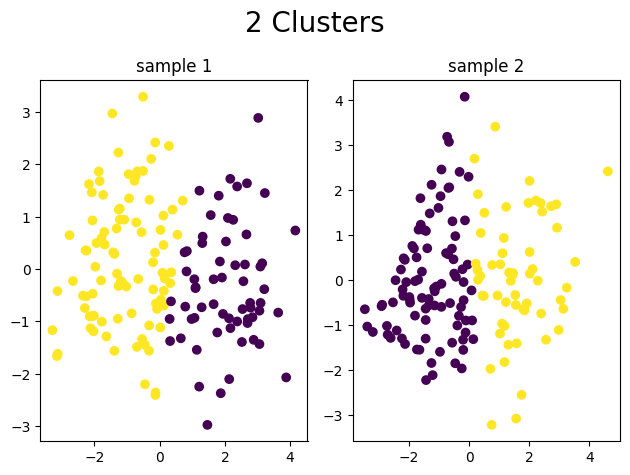

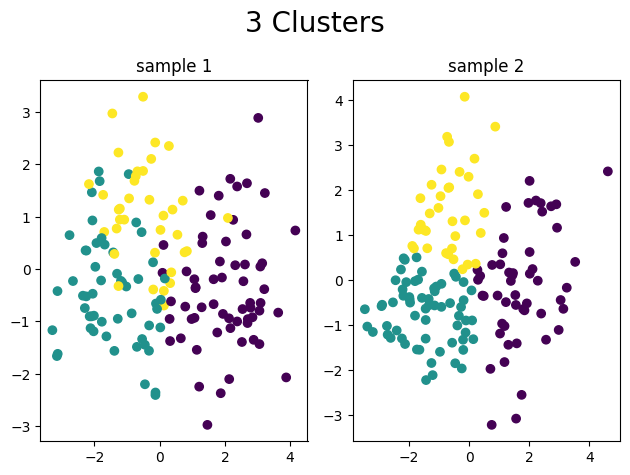

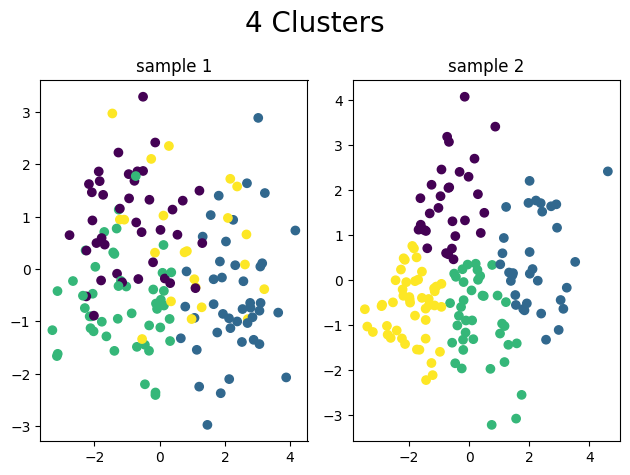

In [36]:
# For each  number of clusters, plot the clusters using the
# PCA features for each sample
for cluster in range(2, 5):

    # Make a grid of subplots
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample
    for i in range(2):

        # PCA-created features
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]

        # Cluster assignments
        c = ypred['clust{}_sample{}'.format(cluster, i)]

        # Assign the subplot to its place on the grid
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i+1))

    # Space out the plots so that the headings don't overlap axis values
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

As expected, two clusters has better performance than three or four (as there are only two possible outcomes - heart disease or no heart disease).

#### Q2(b). Next, apply k-means on the whole dataset by setting k equal to 2, 3, and 4. Get the ARI score for each of them. Which model is best?

In [50]:
preds = []
for i in range(2,5):
  preds.append(KMeans(n_clusters=i, n_init=10, random_state=123).fit_predict(X_std))
  print("ARI for {} cluster k-means: {}".format(i,metrics.adjusted_rand_score(y, preds[i-2])))

ARI for 2 cluster k-means: 0.43661540614807665
ARI for 3 cluster k-means: 0.28069413267888504
ARI for 4 cluster k-means: 0.19689932868308627


Once again, 2 clusters has the highest ARI score and therefore the best performance.

#### Q2(c). As a last exercise, apply k-means on the whole dataset by setting k equal to 2, 3, and 4. Get the silhouette coefficient for each of them. Which model is best?

In [49]:
s_coeffs = []
for i in range(2,5):
  preds.append(KMeans(n_clusters=i, n_init=10, random_state=123).fit_predict(X_std))
  print("Silhouette score for {} cluster k-means: {}".format(i,metrics.silhouette_score(X_std, preds[i-2], metric='euclidean')))

Silhouette score for 2 cluster k-means: 0.17440650461256255
Silhouette score for 3 cluster k-means: 0.12862190702187828
Silhouette score for 4 cluster k-means: 0.13186062012858554


Two clusters has the highest score.